In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# import sys
# sys.path.insert(0, '../')
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"


import numpy as np
import tensorflow as tf

from gantools import data
from gantools import utils
from gantools import plot
from gantools.model import CosmoWGAN, WGAN, LapWGAN, UpscalePatchWGAN
from gantools.gansystem import GANsystem, UpscaleGANsystem
from gantools.data import fmap
from gantools import evaluation
import functools
import matplotlib.pyplot as plt
from copy import deepcopy

# Parameters

In [3]:
ns = 32 # Resolution of the image
try_resume = True # Try to resume previous simulation
Mpch = 350 # Type of dataset (select 70 or 350)

# Do not change these for now
shift = 1
c = 20000
forward = functools.partial(fmap.stat_forward, shift=shift, c=c)
backward = functools.partial(fmap.stat_backward, shift=shift, c=c)

# forward = fmap.stat_forward
# backward = fmap.stat_backward

# Data handling

Load the data

In [4]:
dataset = data.load.load_nbody_dataset(nsamples=10, spix=ns, Mpch=Mpch, forward_map=forward, patch=True, is_3d=False)

Select 10 samples out of 30.
images shape =  (10, 256, 256, 256)


In [5]:
# The dataset can return an iterator.
it = dataset.iter(10)
print(next(it).shape)
del it

(10, 32, 32, 4)


In [6]:
# Get all the data
X = dataset.get_all_data()[:,:,:,0].flatten()

In [7]:
# Check that the backward maps invert the forward map.
# assert(np.sum(np.abs(forward(backward(X))-X))< 5)
# # For debugging
# np.sum(np.abs(forward(backward(X))-X))
# forward(backward(X))-X
# x = np.arange(1e4)
# plt.plot(x, backward(forward(x))-x)

In [8]:
np.sum(np.abs(forward(backward(X))-X))

1.0367049

Display the histogram of the pixel densities after the forward map

min: 0.0
max: 6.287038803100586


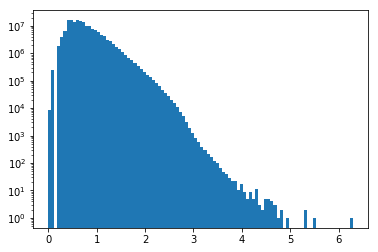

In [9]:
plt.hist(X, 100)
print('min: {}'.format(np.min(X)))
print('max: {}'.format(np.max(X)))
plt.yscale('log')

In [10]:
# to free some memory
del X

Let us plot 16 images

Text(0.5,1,'Real samples')

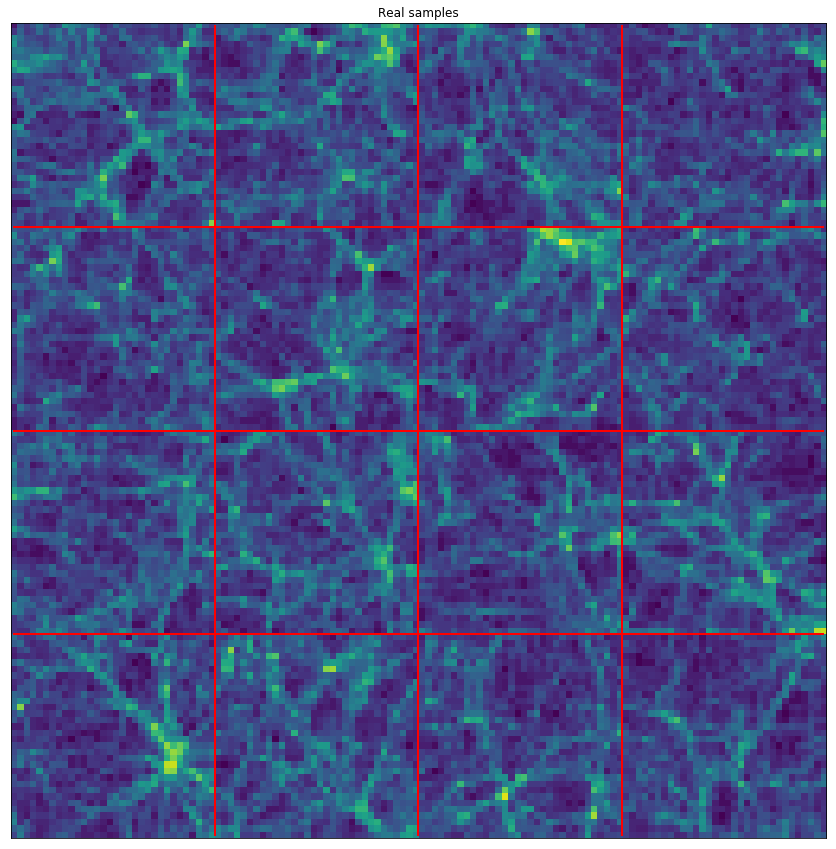

In [11]:
plt.figure(figsize=(15,15))
plot.draw_images(dataset.get_samples(N=16)[:,:,:,0],nx=4,ny=4);
plt.title("Real samples")

# Define parameters for the WGAN

In [12]:
time_str = '2D_patchgan_fft_psd_features_01'
global_path = 'saved_results'

name = 'WGAN{}'.format(ns) + '_' + time_str

## Parameters

In [13]:
bn = False

md=32

params_discriminator = dict()

params_discriminator['stride'] = [2, 2, 2, 1, 1, 1]
params_discriminator['nfilter'] = [2*md, 2*md, md, md//2, md//4,2]
params_discriminator['shape'] = [[4, 4],[4, 4], [4, 4],[4, 4], [4, 4], [4, 4]]
params_discriminator['batch_norm'] = [bn, bn, bn, bn, bn, bn]
params_discriminator['full'] = [64, 16]
params_discriminator['minibatch_reg'] = False
params_discriminator['summary'] = True
params_discriminator['data_size'] = 2
params_discriminator['inception'] = True
params_discriminator['spectral_norm'] = False
params_discriminator['fft_features'] = True
params_discriminator['psd_features'] = True

params_generator = dict()
params_generator['stride'] = [1, 1, 1, 1, 1, 1, 1, 1]
params_generator['latent_dim'] = 32*32
params_generator['latent_dim_split'] = None
params_generator['in_conv_shape'] =[32, 32]
params_generator['nfilter'] = [md, md, md, md, md, md, md, 1]
params_generator['shape'] = [[4, 4],[4, 4], [4, 4],[4, 4], [4, 4], [4, 4]]
params_generator['batch_norm'] = [bn, bn, bn, bn,bn, bn, bn]
params_generator['full'] = []
params_generator['summary'] = True
params_generator['non_lin'] = tf.nn.relu
params_generator['data_size'] = 2
params_generator['inception'] = True
params_generator['spectral_norm'] = False
params_generator['use_Xdown'] = False
params_generator['weights_border'] = True


# Optimization parameters inspired from 'Self-Attention Generative Adversarial Networks'
# - Spectral normalization GEN DISC
# - Batch norm GEN
# - TTUR ('GANs Trained by a Two Time-Scale Update Rule Converge to a Local Nash Equilibrium')
# - ADAM  beta1=0 beta2=0.9, disc lr 0.0004, gen lr 0.0001
# - Hinge loss
# Parameters are similar to the ones in those papers...
# - 'PROGRESSIVE GROWING OF GANS FOR IMPROVED QUALITY, STABILITY, AND VARIATION'
# - 'LARGE SCALE GAN TRAINING FOR HIGH FIDELITY NATURAL IMAGE SYNTHESIS'
# - 'CGANS WITH PROJECTION DISCRIMINATOR'

params_optimization = dict()
params_optimization['batch_size'] = 8
params_optimization['epoch'] = 100
params_optimization['n_critic'] = 5
# params_optimization['generator'] = dict()
# params_optimization['generator']['optimizer'] = 'adam'
# params_optimization['generator']['kwargs'] = {'beta1':0, 'beta2':0.9}
# params_optimization['generator']['learning_rate'] = 0.0004
# params_optimization['discriminator'] = dict()
# params_optimization['discriminator']['optimizer'] = 'adam'
# params_optimization['discriminator']['kwargs'] = {'beta1':0, 'beta2':0.9}
# params_optimization['discriminator']['learning_rate'] = 0.0001

# Cosmology parameters
params_cosmology = dict()
params_cosmology['forward_map'] = forward
params_cosmology['backward_map'] = backward


# all parameters
params = dict()
params['net'] = dict() # All the parameters for the model
params['net']['generator'] = params_generator
params['net']['discriminator'] = params_discriminator
params['net']['cosmology'] = params_cosmology # Parameters for the cosmological summaries
params['net']['prior_distribution'] = 'gaussian'
params['net']['shape'] = [ns, ns, 4] # Shape of the image
params['net']['loss_type'] = 'normalized_wasserstein' # loss ('hinge' or 'wasserstein')
params['net']['gamma_gp'] = 10 # Gradient penalty
params['net']['upscaling'] = 4 

params['optimization'] = params_optimization
params['summary_every'] = 200 # Tensorboard summaries every ** iterations
params['print_every'] = 50 # Console summaries every ** iterations
params['save_every'] = 1000 # Save the model every ** iterations
params['summary_dir'] = os.path.join(global_path, name +'_summary/')
params['save_dir'] = os.path.join(global_path, name + '_checkpoints/')
params['Nstats'] = 1000
params['Nstats_cubes'] = 256






In [14]:
resume, params = utils.test_resume(try_resume, params)
# If a model is reloaded and some parameters have to be changed, then it should be done here.
# For example, setting the number of epoch to 5 would be:
params['optimization']['epoch'] = 5
params['Nstats_cubes'] = 256



No resume, the training will start from the beginning!


# Build the model

In [15]:
class CosmoUpscalePatchWGAN(UpscalePatchWGAN, CosmoWGAN):
    pass
wgan = GANsystem(CosmoUpscalePatchWGAN, params)

Apply attenuation to borders
Generator 
--------------------------------------------------
     The input is of size (?, 1024)
     Reshape to (?, 32, 32, 1)
     Contenate with latent variables to (?, 32, 32, 5)
     0 Inception conv(1x1,3x3,5x5) layer with 32 channels
         Non linearity applied
         Size of the variables: (?, 32, 32, 32)
     1 Inception conv(1x1,3x3,5x5) layer with 32 channels
         Non linearity applied
         Size of the variables: (?, 32, 32, 32)
     2 Inception conv(1x1,3x3,5x5) layer with 32 channels
         Non linearity applied
         Size of the variables: (?, 32, 32, 32)
     3 Inception conv(1x1,3x3,5x5) layer with 32 channels
         Non linearity applied
         Size of the variables: (?, 32, 32, 32)
     4 Inception conv(1x1,3x3,5x5) layer with 32 channels
         Non linearity applied
         Size of the variables: (?, 32, 32, 32)
     5 Inception conv(1x1,3x3,5x5) layer with 32 channels
         Non linearity applied
         Size

# Train the model

In [ ]:
wgan.train(dataset, resume=resume)

# Generate new samples
To have meaningful statistics, be sure to generate enough samples
* 2000 : 32 x 32
* 500 : 64 x 64
* 200 : 128 x 128


In [50]:
_, params = utils.test_resume(True, params)
checkpoint = 152000
wgan = UpscaleGANsystem(CosmoUpscalePatchWGAN, params)

Resume, the training will start from the last iteration!
Apply attenuation to borders
Generator 
--------------------------------------------------
     The input is of size (?, 1024)
     Reshape to (?, 32, 32, 1)
     Contenate with latent variables to (?, 32, 32, 5)
     0 Inception conv(1x1,3x3,5x5) layer with 32 channels
         Non linearity applied
         Size of the variables: (?, 32, 32, 32)
     1 Inception conv(1x1,3x3,5x5) layer with 32 channels
         Non linearity applied
         Size of the variables: (?, 32, 32, 32)
     2 Inception conv(1x1,3x3,5x5) layer with 32 channels
         Non linearity applied
         Size of the variables: (?, 32, 32, 32)
     3 Inception conv(1x1,3x3,5x5) layer with 32 channels
         Non linearity applied
         Size of the variables: (?, 32, 32, 32)
     4 Inception conv(1x1,3x3,5x5) layer with 32 channels
         Non linearity applied
         Size of the variables: (?, 32, 32, 32)
     5 Inception conv(1x1,3x3,5x5) layer with

In [51]:
from gantools.blocks import downsample

In [52]:
Nsample = 512
X_real = dataset._X[:Nsample]
X_down = downsample(X_real, 4)

In [53]:
X_fake = wgan.upscale_image(small=np.expand_dims(X_down, axis=3), checkpoint=checkpoint)

 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from saved_results/WGAN32_2D_patchgan_fft_psd_features_01_checkpoints/upscale_patch_wgan-152000
Checkpoint successfully loaded!
(512, 64, 64, 1)
Current patch: column=1, row=1
Sampling z
(512, 64, 64, 1)
Current patch: column=1, row=2
Sampling z
(512, 64, 64, 1)
Current patch: column=1, row=3
Sampling z
(512, 64, 64, 1)
Current patch: column=1, row=4
Sampling z
(512, 64, 64, 1)
Current patch: column=1, row=5
Sampling z
(512, 64, 64, 1)
Current patch: column=1, row=6
Sampling z
(512, 64, 64, 1)
Current patch: column=1, row=7
Sampling z
(512, 64, 64, 1)
Current patch: column=1, row=8
Sampling z
(512, 64, 64, 1)
Current patch: column=2, row=1
Sampling z
(512, 64, 64, 1)
Current patch: column=2, row=2
Sampling z
(512, 64, 64, 1)
Current patch: column=2, row=3
Sampling z
(512, 64, 64, 1)
Current patch: column=2, row=4
Sampling z
(512, 64, 64, 1)
Current patch: column=2, row=5
Sampling z
(512, 64, 64, 1)
Current patch: column=2

Display a few fake samples

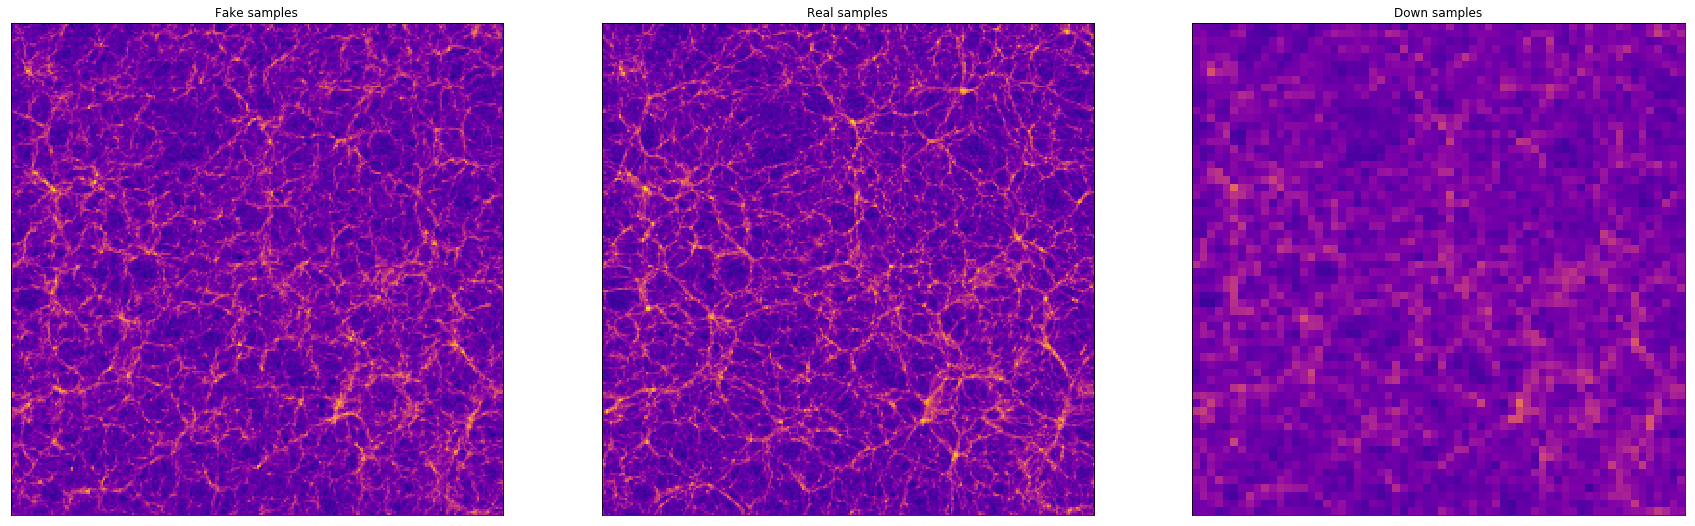

In [54]:
clim = (0,3)
plt.figure(figsize=(30,10))
plt.subplot(131)
plot.draw_images(X_fake,nx=1,ny=1,vmin=clim[0], vmax=clim[1], cmap = plt.cm.plasma);

plt.title("Fake samples");
plt.subplot(132)
plot.draw_images(X_real,nx=1,ny=1,vmin=clim[0], vmax=clim[1], cmap = plt.cm.plasma);
plt.title("Real samples");
plt.subplot(133)
plot.draw_images(X_down,nx=1,ny=1,vmin=clim[0], vmax=clim[1], cmap = plt.cm.plasma);
plt.title("Down samples");


# Evaluation of the sample quality

In [55]:
# Before computing the statistics, we need to invert the mapping
raw_images = backward(X_real)
gen_sample_raw = backward(X_fake)

Log l2 PSD loss: 0.4168714175064134
L2 PSD loss: 157.14482386794958
Log l1 PSD loss: 0.5075865216455667
L1 PSD loss: 7.6812353217025615


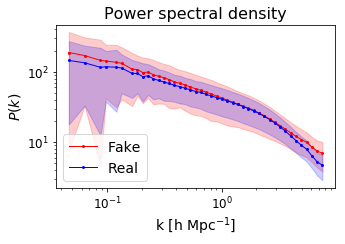

In [56]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_psd(raw_images, gen_sample_raw)

Log l2 Peak Count loss: 0.29604864179245427
L2 Peak Count loss: 6.396008151375621e-05
Log l1 Peak Count loss: 0.42297554208867805
L1 Peak Count loss: 0.0056637549392754526


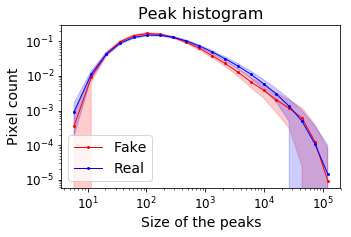

In [57]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_peak_cout(raw_images, gen_sample_raw)

Log l2 Mass histogram loss: 0.11031917581454712
L2 Peak Mass histogram: 7.112510123379323e-05
Log l1 Mass histogram loss: 0.2287279228923845
L1 Mass histogram loss: 0.0039560914039611815


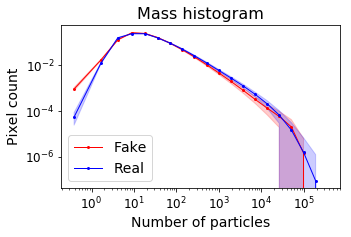

In [58]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_mass_hist(raw_images, gen_sample_raw)